In [1]:
import os
os.chdir('/home/jovyan/wav2betterlip')
import torch
from torch.utils.data import Dataset
from skimage import io as skimageio
from tqdm.auto import tqdm
from utils.spath import *
from utils.sdraw import *
from utils.smath import *
from utils.basel import Basel
from wav2lip import audio
!pwd
!pip install wandb
!pip install pyarrow

import pandas as pd
import wandb
from sklearn.utils import shuffle
from wav2lip.models.conv import Conv2dTranspose, Conv2d, nonorm_Conv2d



/home/jovyan/wav2betterlip


In [ ]:
wandb.login(key="")

In [2]:
device = "cuda:3"
basel = Basel(device=device)
basel_cpu = Basel(device="cpu")

In [3]:
df = pd.read_parquet('workspace/updated_data.pq')

In [4]:
# df.to_parquet('workspace/updated_data.pq',index=False)

In [5]:
# df['landmarks_aligned'] = "workspace/" + df["directory"] + "/full.landmarks_aligned"

In [6]:
# df.to_parquet('workspace/updated_data.pq')

In [7]:
# lpm  = [str(p) for p in glob(os.path.join("workspace", '**/*full*'), recursive=True)]
# df = df[df.expression.isin(lpm)]
df

directory  \
0        5535415699068794046/00001   
1        5535415699068794046/00001   
2        5535415699068794046/00001   
3        5535415699068794046/00001   
4        5535415699068794046/00001   
...                            ...   
2611536  6393267985458244248/00017   
2611537  6393267985458244248/00017   
2611538  6393267985458244248/00017   
2611539  6393267985458244248/00017   
2611540  6393267985458244248/00017   

                                                deepspeech  \
0        workspace/5535415699068794046/00001/00000.deep...   
1        workspace/5535415699068794046/00001/00001.deep...   
2        workspace/5535415699068794046/00001/00002.deep...   
3        workspace/5535415699068794046/00001/00003.deep...   
4        workspace/5535415699068794046/00001/00004.deep...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/00022.deep...   
2611537  workspace/6393267985458244248/00017/00023.deep...   
2611538  workspace/6393267985458244248/00017/00024.deep...   
2611539  workspace/6393267985458244248/00017/00025.deep...   
2611540  workspace/6393267985458244248/00017/00026.deep...   

                                                 landmarks  \
0        workspace/5535415699068794046/00001/00000.land...   
1        workspace/5535415699068794046/00001/00001.land...   
2        workspace/5535415699068794046/00001/00002.land...   
3        workspace/5535415699068794046/00001/00003.land...   
4        workspace/5535415699068794046/00001/00004.land...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/00022.land...   
2611537  workspace/6393267985458244248/00017/00023.land...   
2611538  workspace/6393267985458244248/00017/00024.land...   
2611539  workspace/6393267985458244248/00017/00025.land...   
2611540  workspace/6393267985458244248/00017/00026.land...   

                                         landmarks_aligned  \
0        workspace/5535415699068794046/00001/full.landm...   
1        workspace/5535415699068794046/00001/full.landm...   
2        workspace/5535415699068794046/00001/full.landm...   
3        workspace/5535415699068794046/00001/full.landm...   
4        workspace/5535415699068794046/00001/full.landm...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/full.landm...   
2611537  workspace/6393267985458244248/00017/full.landm...   
2611538  workspace/6393267985458244248/00017/full.landm...   
2611539  workspace/6393267985458244248/00017/full.landm...   
2611540  workspace/6393267985458244248/00017/full.landm...   

                                                  shape  \
0        workspace/5535415699068794046/00001/full.shape   
1        workspace/5535415699068794046/00001/full.shape   
2        workspace/5535415699068794046/00001/full.shape   
3        workspace/5535415699068794046/00001/full.shape   
4        workspace/5535415699068794046/00001/full.shape   
...                                                 ...   
2611536  workspace/6393267985458244248/00017/full.shape   
2611537  workspace/6393267985458244248/00017/full.shape   
2611538  workspace/6393267985458244248/00017/full.shape   
2611539  workspace/6393267985458244248/00017/full.shape   
2611540  workspace/6393267985458244248/00017/full.shape   

                                                expression  \
0        workspace/5535415699068794046/00001/full.expre...   
1        workspace/5535415699068794046/00001/full.expre...   
2        workspace/5535415699068794046/00001/full.expre...   
3        workspace/5535415699068794046/00001/full.expre...   
4        workspace/5535415699068794046/00001/full.expre...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/full.expre...   
2611537  workspace/6393267985458244248/00017/full.expre...   
2611538  workspace/6393267985458244248/00017/full.expre...   
2611

In [8]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
audioargs = AttrDict()



###! audio settings

audioargs.num_mels = 80  # Number of mel-spectrogram channels and local conditioning dimensionality
#  network
audioargs.rescale = True  # Whether to rescale audio prior to preprocessing
audioargs.rescaling_max = 0.9  # Rescaling value

# Use LWS (https://github.com/Jonathan-LeRoux/lws) for STFT and phase reconstruction
# It"s preferred to set True to use with https://github.com/r9y9/wavenet_vocoder
# Does not work if n_ffit is not multiple of hop_size!!
audioargs.use_lws = False

audioargs.n_fft = 800  # Extra window size is filled with 0 paddings to match this parameter
audioargs.hop_size = 200  # For 16000Hz, 200 = 12.5 ms (0.0125 * sample_rate)
audioargs.win_size = 800  # For 16000Hz, 800 = 50 ms (If None, win_size = n_fft) (0.05 * sample_rate)
audioargs.sample_rate = 16000  # 16000Hz (corresponding to librispeech) (sox --i <filename>)

audioargs.frame_shift_ms = None  # Can replace hop_size parameter. (Recommended: 12.5)

# Mel and Linear spectrograms normalization/scaling and clipping
audioargs.signal_normalization = True
# Whether to normalize mel spectrograms to some predefined range (following below parameters)
audioargs.allow_clipping_in_normalization = True  # Only relevant if mel_normalization = True
audioargs.symmetric_mels = True
# Whether to scale the data to be symmetric around 0. (Also multiplies the output range by 2, 
# faster and cleaner convergence)
audioargs.max_abs_value = 4.
# max absolute value of data. If symmetric, data will be [-max, max] else [0, max] (Must not 
# be too big to avoid gradient explosion, 
# not too small for fast convergence)
# Contribution by @begeekmyfriend
# Spectrogram Pre-Emphasis (Lfilter: Reduce spectrogram noise and helps model certitude 
# levels. Also allows for better G&L phase reconstruction)
audioargs.preemphasize = True  # whether to apply filter
audioargs.preemphasis = 0.97  # filter coefficient.

# Limits
audioargs.min_level_db = -100
audioargs.ref_level_db = 20
audioargs.fmin = 55
# Set this to 55 if your speaker is male! if female, 95 should help taking off noise. (To 
# test depending on dataset. Pitch info: male~[65, 260], female~[100, 525])
audioargs.fmax = 7600  # To be increased/reduced depending on data.

In [33]:
import functools
import time

class AudioToExpressionDataset(Dataset):
    
    def __init__(self,device='cpu',df=None,subset_df=None,T=3):
        
        self.device=device
        self.df = df       
        self.subset_df = subset_df
        self.T=T # the sequence length
        self.syncnet_mel_step_size = 16
        
        print("init dataset")
        
    def build_pandas(self,vid_path='workspace'):
        paths = []
        aligned_landmark_paths = [str(p) for p in glob(os.path.join(vid_path, '**/*.landmarks'), recursive=True)]
        aligned_landmark_paths.sort()
        data = []
        for lmrk in tqdm(aligned_landmark_paths):
            p = dirname(lmrk)
            extensions = ['deepspeech',"landmarks",'landmarks_aligned',"shape","expression","jpeg"]
            tmp = {"directory":str(relpath(p,vid_path))}
            for extension in extensions:
                extension_path = p/(str(Path(lmrk).stem).zfill(5) + "." + extension)
                if not os.path.exists(extension_path):
                    print(extension_path)
                    break
                tmp[extension] = extension_path
            else:
                data.append(tmp)
            
            paths.append(str(p/Path(lmrk).stem))
        return pd.DataFrame(data)
                
    def __len__(self):
        return len(self.df if self.subset_df is None else self.subset_df)
    
    @functools.lru_cache(maxsize=None)
    def load_full(self,path):
        return torch.load(path)
    
    def load_deepspeech(self,idx):
        return torch.load(self.df.iloc[idx]["deepspeech"]).to(self.device)
    
    def load_expression(self,idx):
        return self.load_full(self.df.iloc[idx]["expression"])[self.df.iloc[idx]['offset']]
    
    def load_aligned_landmarks(self,idx):
        return self.load_full(self.df.iloc[idx]["landmarks_aligned"])[self.df.iloc[idx]['offset']]
    
    def load_shape(self,idx):
        return self.load_full(self.df.iloc[idx]["shape"])
    
    @functools.lru_cache(maxsize=None)
    def load_landmarks(self,idx):
        return torch.load(self.df.iloc[idx]["landmarks"]).to(self.device)
    
    @functools.lru_cache(maxsize=None)
    def load_face(self,idx):
        return skimageio.imread(self.df.iloc[idx]["jpeg"])
     
    def get_video_df(self,idx):
        return self.df.iloc[idx-self.df.iloc[idx]['offset']:idx-self.df.iloc[idx]['offset']+self.df.iloc[idx]['size']]
        
    def load_video_expressions(self,idx=None,subset_idx=None):
        if not subset_idx is None:
            idx = self.subset_to_full(subset_idx)
        video_df = self.get_video_df(idx)
        expressions = []
        for row_idx in video_df.index.tolist():
            expressions.append(self.load_expression(row_idx))
        return expressions, self.df.iloc[idx]['offset']
    
    def load_video_shapes(self,idx=None,subset_idx=None):
        if not subset_idx is None:
            idx = self.subset_to_full(subset_idx)
        video_df,row = self.get_video_df(idx)
        expressions = []
        for row_idx in video_df.index.tolist():
            expressions.append(self.load_shape(row_idx))
        return expressions, idx - video_df.index.tolist()[0]
    
    def plot_face(self,idx,mode="real"):
        if mode=="real":
            landmarks = self.load_landmarks(idx).cpu()
            img = self.load_face(idx)
            plot_faces([landmarks],[img],lines=FACE_LINES)
        if mode=="basel":
            expression = self.load_expression(idx)
            shape = self.load_shape(idx)
            dlib = basel_cpu.get_face(shape,expression).cpu()
            smart_plot(dlib,titles=["face"],lines=FACE_LINES)
        if mode=="aligned":
            dlib = self.load_aligned_landmarks(idx)
            smart_plot(dlib,titles=["face"],lines=FACE_LINES)

    def subset_to_full(self,subset_idx):
        return self.subset_df.loc[subset_idx]['index']
    
    def crop_audio_window(self, spec, start_frame):
        start_frame_num = start_frame
        start_idx = int(80. * (start_frame_num / float(25))) #fps
        end_idx = start_idx + self.syncnet_mel_step_size # 16 == 80/25*5 syncnet_t, really unclear from the paper

        return spec[start_idx : end_idx, :]
    
    def get_segmented_mels(self, spec, start_frame):
        mels = []
        start_frame = offset = self.df.iloc[start_frame]['offset']
        size = self.df.iloc[start_frame]['size']
        
        for i in range(offset, offset + self.T):
            m = self.crop_audio_window(spec, i-self.T//2)
            if m.shape[0] != self.syncnet_mel_step_size:
                #at the end of the video
                print("start_frame",start_frame)
                print("mismel",m.shape)
                return None
            mels.append(m.T)
        mels = np.asarray(mels)

        return mels
    
    @functools.lru_cache(maxsize=None)
    def get_wav(self,audiopath):
        return audio.load_wav(os.path.join("workspace",audiopath,"audio.wav"), audioargs.sample_rate)
    
    
    def get_audio_window(self,idx):
        wav = self.get_wav(self.df.iloc[idx]['directory'])
        
        orig_mel = audio.melspectrogram(wav,audioargs).T
        mel = self.crop_audio_window(orig_mel.copy(), df.iloc[idx]['offset'])
        mel = torch.FloatTensor(mel.T).unsqueeze(0)
        
        indiv_mels = self.get_segmented_mels(orig_mel.copy(), idx)
        indiv_mels = torch.FloatTensor(indiv_mels).unsqueeze(1)
        
        data = {}
        data['mel'] = mel
        data['individual_mels'] = indiv_mels
        return data    
    
    
    def get_offset(self,idx):
        return self.df.iloc[idx]['offset']
    
    def getitem(self,idx):    
        offset =  self.df.iloc[idx]['offset']
        size = self.df.iloc[idx]['size']
        if size <= 10: return self.getitem(idx+10)
        if offset - self.T//2 < 0: idx+=self.T//2
        #we need 2*syncnet, to ensure the mels fit
        if offset + 8 > size: idx = idx - offset + size - 8

        return {"expression":self.load_expression(idx),
                "idx":idx,
                **self.get_audio_window(idx),
               }
             
    def __getitem__(self, idx,subset=True):
        try:
            if subset:
                cur  = self.getitem(self.subset_to_full(idx))
                prev = self.getitem(max(self.subset_to_full(idx)-1,0))
                nxt  = self.getitem(min(self.subset_to_full(idx)+1,len(self)-1))
            else:
                cur  = self.getitem(idx)
                prev = self.getitem(max(idx-1,0))
                nxt  = self.getitem(min(idx+1,len(self)-1))
        except Exception as e:
            print(idx)
            print("subsettofull:" + str(self.subset_to_full(idx)))
            print("subsettofull2:", max(self.subset_to_full(idx)-1,0))
            print("subsettofull3:" , min(self.subset_to_full(idx)+1,len(self)-1))
            
            raise e
            
        return {
            "cur":cur,
            "prev":prev,
            "nxt":nxt
        }

A2ED = AudioToExpressionDataset(df=df,subset_df=df.reset_index(),T=3)
A2ED.__getitem__(1017689,False)
#A2ED.df= df = A2ED.build_pandas()

# df.drop(columns=['Unnamed: 0'],inplace=True)
# df.drop(columns=['Unnamed: 0.1'],inplace=True)

# df.to_csv("workspace/data.csv",index=False)


init dataset


{'cur': {'expression': tensor([-0.2802, -0.4071, -1.0752,  0.9276,  0.3924, -0.7507, -0.1229,  1.1536,
           2.4803, -0.7643,  0.7173,  0.8858, -1.9263,  2.4749, -1.9101,  2.2953,
          -5.2060,  0.4316, -0.4154, -0.6160,  0.3302, -0.0847,  2.2621,  0.3689,
          -0.7072,  1.6195, -0.3886,  0.5688, -2.6647,  1.0369, -2.4292,  1.5576,
          -1.1359,  3.1905,  2.1825,  2.5221, -0.2804,  1.0014, -1.0684, -3.5442,
           0.5798, -1.7239,  1.2303,  2.6502,  0.3645, -0.9254,  0.5814,  0.3243,
          -0.1494, -1.2182,  3.0244,  2.6610,  4.0657,  0.6535, -0.5091,  2.0526,
          -4.3258, -0.5753, -4.0502,  1.0446, -2.8018, -0.3864, -1.4638, -0.7747,
          -1.1352, -1.4943, -1.0592, -3.2686, -2.0314, -1.4351,  0.5116,  4.2984,
          -0.6802, -0.5899,  0.7503, -1.2055,  0.5078,  1.8281, -1.5279,  1.8362,
          -2.5659,  2.4631,  0.3184, -0.5509,  1.1681,  4.6488, -2.9996, -2.4062,
           1.9901,  0.9476,  1.3269, -0.9753,  1.6431, -2.3973,  0.4183, -2.0

In [10]:
A2ED.load_video_expressions(36)

([tensor([-1.8394,  0.5823, -2.2051, -0.4851,  0.3352, -2.4866, -0.4327,  0.9282,
          -0.4148, -1.6134,  0.5133, -1.5481, -0.5411, -0.3725,  0.3241,  1.2958,
          -2.0448,  0.5660,  0.9384, -0.8465, -0.2756,  0.7392, -0.5979, -1.5044,
           0.1009, -1.2857, -1.8101,  3.8149,  0.1622,  0.8667,  0.7467, -1.1867,
           3.0774,  2.3191, -0.4049,  1.3595,  2.9499,  2.4550,  1.8961, -1.0083,
          -1.1968,  1.0603,  2.1708,  1.5094, -2.8668, -3.0422,  0.1443,  2.3385,
          -1.2198,  1.8361, -0.8209,  0.9558, -0.2629, -2.6922,  4.2351,  3.0852,
           1.1674,  0.5253, -1.1640,  0.0535, -0.3411, -0.6843, -1.1042, -2.5756,
          -1.7545, -0.5023,  0.2583, -0.7380, -4.1630, -2.5674,  3.0655, -2.3473,
           0.6494, -5.4220, -1.1582, -0.6032,  0.2945,  0.4536, -0.7608,  0.1260,
          -0.7888,  0.7224, -1.8226, -3.5351,  0.9833,  3.5465, -0.5329,  0.1083,
          -0.5906, -4.3592, -2.7986,  0.1215,  0.8998, -3.1071, -1.8723, -3.2035,
           1.896

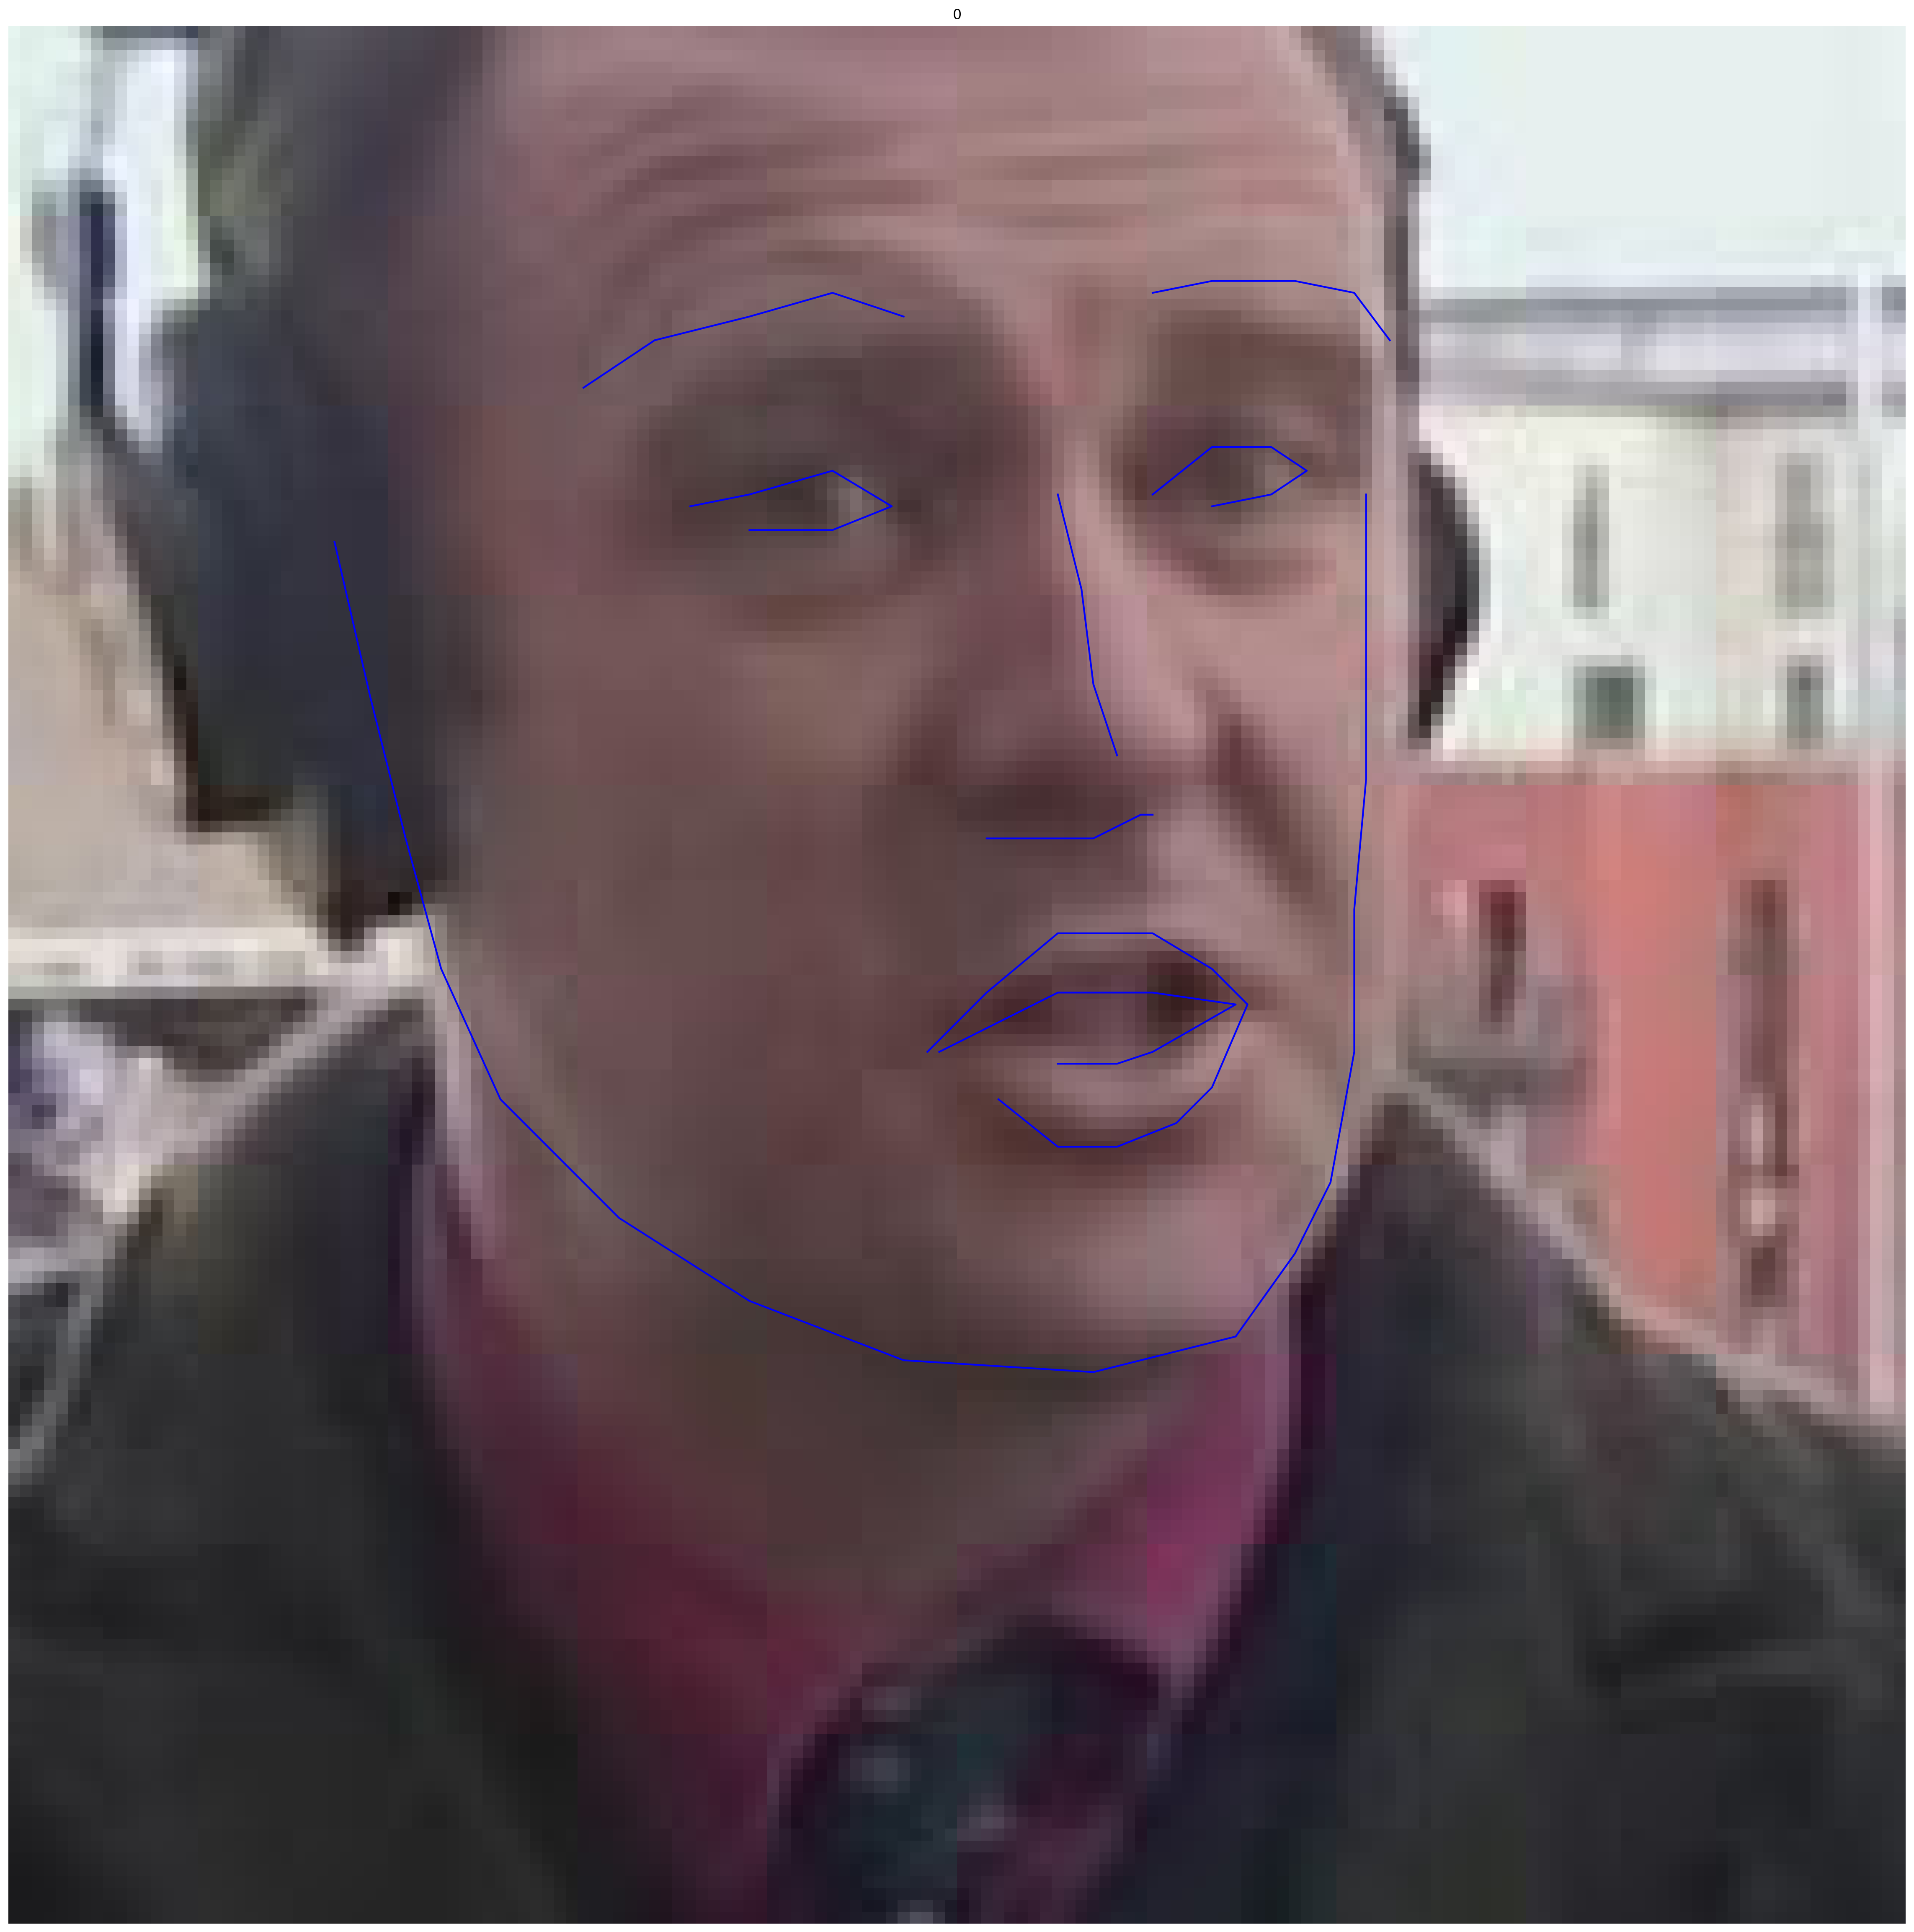

In [11]:
A2ED.plot_face(13100,"real")

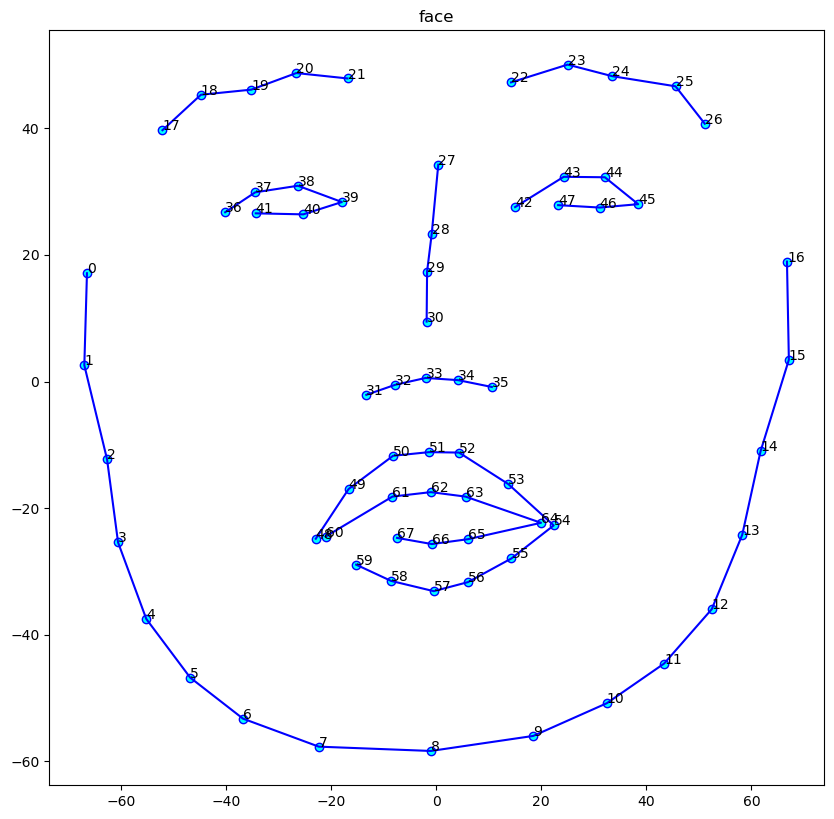

In [12]:
A2ED.plot_face(13100,"basel")

In [13]:
A2ED_train = AudioToExpressionDataset(df=df,subset_df = shuffle(df[df['datasplit']=="train"])[:10000].reset_index(),)


init dataset


In [14]:
A2ED_train.__getitem__(300)

???
int idx 2004642
???
int idx 2004633
???
int idx 9999


{'cur': {'expression': tensor([-0.7308,  0.2326, -1.3753,  0.4390,  0.0084, -1.2858,  0.7668,  1.4570,
          -0.3339, -0.4182,  0.6771,  1.9085, -1.2181,  2.4334,  1.6302,  0.8093,
          -2.4559, -0.6055,  0.7688,  0.4611,  0.0630,  2.6644,  0.6931, -2.0199,
           0.7302,  2.0100,  0.4700,  2.1856, -2.3611,  0.7591, -0.9708, -1.9787,
          -0.0629,  0.5883, -0.4539,  4.4691,  2.3631,  0.9908,  2.3489, -0.3980,
           1.3716,  1.1767,  2.2777,  4.8725, -2.7843, -3.4204, -0.9531,  1.0644,
          -0.3799,  1.1339,  1.9827,  0.7779,  1.8581, -1.0340,  3.1342, -0.8549,
           0.5032, -1.9237, -2.8978,  0.8477,  1.6105,  0.6487, -3.6435, -0.7538,
          -0.7082, -1.1637,  0.0742,  1.5500, -0.3008, -3.2597,  2.1886,  0.4003,
           3.9219, -4.1266, -3.2096, -0.0241, -1.4262, -1.7195,  0.0561, -1.0523,
           0.2706, -1.3704, -0.4671, -0.5932,  0.8303,  1.0947,  2.4398, -2.9005,
          -0.1167, -2.2234,  0.1895, -1.2903,  2.3347, -0.9096,  1.6603, -0.6

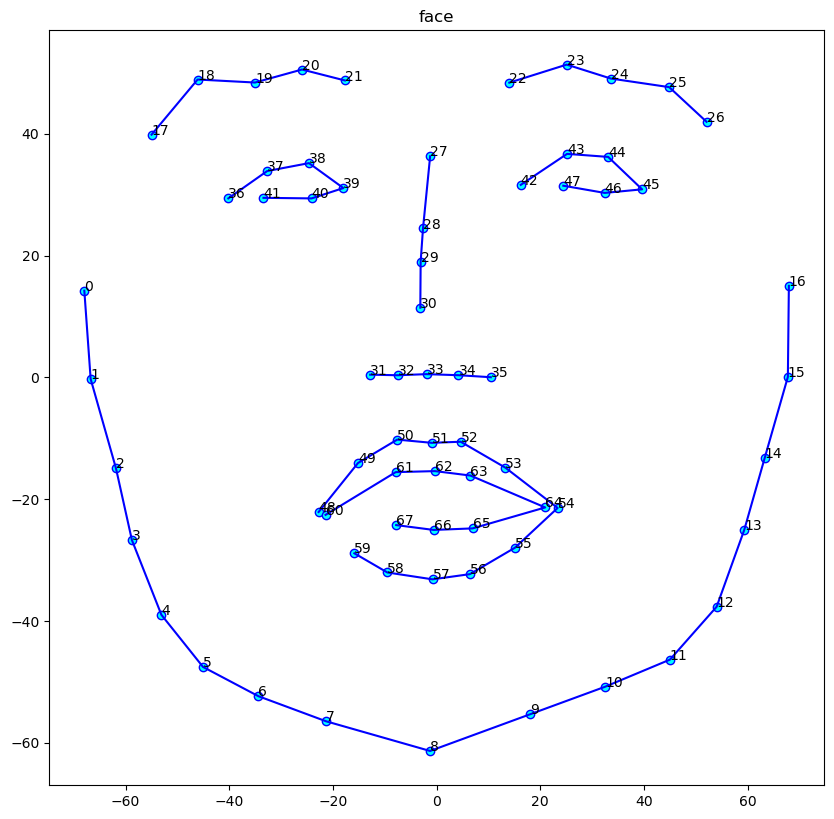

In [15]:
A2ED_train.plot_face(400,"basel")

In [16]:
loaded_expressions,_ = A2ED_train.load_video_expressions(100)

In [165]:
def match_expression(source_expression,stacked_expression,device,multipliers=(1,10),metric="L2",displacement = 1,print_loss=False):
    if type(source_expression)==list: 
        source_expression = torch.stack(source_expression)
    if type(stacked_expression)==list: 
        stacked_expression = torch.stack(stacked_expression)
        
    if "cpu" in device: 
        source_dlib = basel_cpu.get_expression(source_expression,2)
        stacked_dlib = basel_cpu.get_expression(stacked_expression,2)
    else:
        source_dlib = basel.get_expression(source_expression,2)
        stacked_dlib = basel.get_expression(stacked_expression,2)
    
    if len(source_dlib.shape)==2:
        source_dlib = source_dlib[None,None,:,:] 
    elif len(source_dlib.shape)==3:
        source_dlib = source_dlib[:,None,:,:] 
    
    stacked_dlib = stacked_dlib[None,:,:,:]
    
    
    
    mouth_idxs_norm = list(range(48, 68))
    mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:]
    mouth_source = source_dlib[:,:,mouth_idxs_norm,:]
    
    
    if displacement>0:
        idxs = list(range(68))
        idxs.append(idxs.pop(0))

        mouth_idxs_shifted = list(mouth_idxs_norm)
        for disp in range(displacement):
            mouth_idxs_shifted.append(mouth_idxs_shifted.pop(0))

        mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:] - stacked_dlib[:,:,mouth_idxs_shifted,:]
        mouth_source = source_dlib[:,:,mouth_idxs_norm,:] - source_dlib[:,:,mouth_idxs_shifted,:]

        stacked_dlib = stacked_dlib - stacked_dlib[:,:,idxs,:]
        source_dlib = source_dlib - source_dlib[:,:,idxs,:]
            
    
    if metric.upper()=="L1":
        face_loss = multipliers[0]*torch.abs(stacked_dlib - source_dlib).sum(dim=[2,3])
        mouth_loss =  multipliers[1]* torch.abs(mouth_stacked - mouth_source).sum(dim=[2,3])
        z = face_loss + mouth_loss
    if metric.upper()=="L2":
        face_loss = multipliers[0]* (stacked_dlib  - source_dlib).square().sum(dim=[2,3])
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).square().sum(dim=[2,3])
        z = face_loss + mouth_loss
    if metric.upper()=="RMS":
        face_loss = multipliers[0]* (stacked_dlib  - source_dlib).square().sum(dim=[2,3]).sqrt()
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).square().sum(dim=[2,3]).sqrt()
        z = face_loss + mouth_loss
    
    
    if print_loss: 
        print(f"face: {face_loss.max()} mouth_loss {mouth_loss.max()}")
    sorted, indices = torch.sort(z,dim=1)
    if print_loss:print(sorted) 

    return indices[0].tolist()

match_expression(loaded_expressions[1],loaded_expressions,"cpu",print_loss=True,displacement=1,multipliers=(1,10)).index(1)
    

face: 791.2296752929688 mouth_loss 2035.1123046875
tensor([[4.6381e-10, 3.1140e+02, 4.1708e+02, 4.5305e+02, 4.5804e+02, 4.9407e+02,
         5.2745e+02, 6.1720e+02, 6.3095e+02, 6.6678e+02, 6.6695e+02, 6.7770e+02,
         6.9416e+02, 7.4772e+02, 7.4878e+02, 7.7019e+02, 8.1701e+02, 8.9743e+02,
         9.0058e+02, 9.1611e+02, 9.3421e+02, 9.6354e+02, 1.1487e+03, 1.1508e+03,
         1.1981e+03, 1.2058e+03, 1.3429e+03, 1.6295e+03, 1.8049e+03, 2.0357e+03,
         2.3376e+03, 2.3693e+03, 2.4169e+03, 2.4572e+03, 2.5025e+03]])


0

In [18]:
# train_size = 0.8
# df = A2ED.df
# df['datasplit'] = 'test'

# g = df.groupby("directory")

# a=np.arange(g.ngroups)
# np.random.shuffle(a)

# cutoff = int(g.ngroups*train_size)
# df.loc[g.ngroup().isin(a[:cutoff]),'datasplit']='train'
# df.to_csv('workspace/data.csv')

# print(len(df[df['datasplit']=="train"])/len(df))
# len(df[df['datasplit']=="train"])

In [19]:
import torch.nn as nn
import torch

class LipGenerator(nn.Module):
    def __init__(self,T=3):
        super().__init__()
        self.T=T
        #################################
        #########   lip net   ###########
        #################################

        self.convNet = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
        )
        


        self.linearNet = nn.Sequential(
            nn.Linear(in_features = 512 , out_features=400, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 400, out_features=400, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 400, out_features=300, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 300, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=100, bias = True),
        )
        
        self.attentionConvNet = nn.Sequential( # b x subspace_dim x seq_len
            nn.Conv1d(100, 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(4, 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(2, 1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True)
        )
        self.attentionNet = nn.Sequential(
            nn.Linear(in_features = self.T, out_features=self.T, bias = True),   
            nn.Softmax(dim=1)
        )
        

    def forward(self,deepspeech):
        b = deepspeech.shape[0] # batchsize
        
        deepspeech = deepspeech.view(b * self.T,1, 80, 16 ) # b * seq_len x 80 x 16
                    
            
        audio_sequences = torch.cat([deepspeech[:, i] for i in range(deepspeech.size(1))], dim=0)
        
        conved = self.convNet(deepspeech) # b * seq_len X 128 X 1 X 1
        
        conved = torch.reshape( conved, (b * self.T, 1, -1)) # b * seq_len X 1 X 128
        
        linear = self.linearNet(conved)[:,0,:]

        #################
        ### attention ###
        ################# 
        
        result_subspace = linear.view(b, self.T, 100) 
        result_subspace_T = torch.transpose(result_subspace, 1, 2) # b x subspace_dim x seq_len
        
        intermediate_expression = result_subspace_T[:,:,(self.T // 2):(self.T // 2) + 1] 
        
        
        att_conv_res = self.attentionConvNet(result_subspace_T) 
        
        attention = self.attentionNet(att_conv_res.view(b, self.T)).view(b, self.T, 1) # b x seq_len x 1
        
        result_subspace = torch.bmm(result_subspace_T, attention)
        return result_subspace.squeeze(),intermediate_expression.squeeze()


lip = LipGenerator()
for n in A2ED:
    lip(n['cur']['individual_mels'].unsqueeze(0))
    break
            

???
int idx 1
???
int idx 1
???
int idx 1


In [20]:
class MultiEpochsDataLoader(torch.utils.data.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._DataLoader__initialized = False
        self.batch_sampler = _RepeatSampler(self.batch_sampler)
        self._DataLoader__initialized = True
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)
    
    def __del__(self):
        del self.iterator

class _RepeatSampler(object):
    """ Sampler that repeats forever.
    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)

# df=pd.read_csv('workspace/data.csv')
def get_loaders(args):
    
    
    A2ED_train = AudioToExpressionDataset(df=df,subset_df=shuffle(df[df['datasplit']=="train"])[:args.data_size].reset_index(),T=args.seq_length)
    A2ED_test = AudioToExpressionDataset(df=df,subset_df=shuffle(df[df['datasplit']=="test"])[:args.data_size].reset_index(),T=args.seq_length)
    
    dataloader_params = {
         "batch_size":args.batch_size,
        "shuffle":args.shuffle, 
        "num_workers":args.num_workers,
#         "collate_fn":fn_collate,
    }
    if args.num_workers>0:
        dataloader_params["prefetch_factor"]=args.prefetch

    trainloader = MultiEpochsDataLoader(A2ED_train,**dataloader_params)

    testloader = torch.utils.data.DataLoader(A2ED_test,**dataloader_params)
    
    return {"test":testloader,
           "train":trainloader}

In [21]:
import torch.optim as optim

def lr_decay(step, init_learning_rate = 1e-3, min_learning_rate = 1e-5, decay_rate = 0.9999):
    lr = ((init_learning_rate - min_learning_rate) *
          pow(decay_rate, step) +
          min_learning_rate)
    return lr

def build_model(args):
    model = LipGenerator(T=args.seq_length).to(device)
    
    if args.optimizer=="adam":
        optimizer = optim.Adam(model.parameters(), lr=args.init_learning_rate)
    if args.optimizer=="ranger":
        optimizer = Ranger(model.parameters(), lr=args.init_learning_rate)
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: lr_decay(step,args.init_learning_rate,args.min_learning_rate,args.decay_rate)/args.init_learning_rate)
    if not args.pretrained == "":
        model.load_state_dict(torch.load(args.pretrained))

    return model,optimizer,scheduler

for x in range(10):
    print(lr_decay(x,0.1,0.0001,0.9))


0.1
0.09001
0.08101900000000001
0.07292710000000001
0.06564439000000001
0.05908995100000001
0.05319095590000001
0.04788186031000001
0.04310367427900001
0.03880330685110001


In [22]:
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [23]:
def train_and_test(model,optimizer,scheduler,loaders,args):
    running_loss = 0
    best_loss = -1
    step = 0
    torch.autograd.set_detect_anomaly(args.detect_anomaly)
    
    for epoch in tqdm(range(args.epochs)):  # loop over the dataset multiple times

        
        for split in ['train','test']:
            running_loss = 0

            if split == "train":
                model.train()
                loader = loaders['train']
                max_steps = args.trainsteps_per_epoch
            else:
                model.eval()
                loader=loaders['test']
                max_steps = args.test_steps_per_epoch
            running_loss = 0
            running_mouth_loss =0
            for i, data in enumerate(tqdm(loader)):
                # get the inputs; data is a list of [inputs, labels]
#                 audio, ground_expression_vector, ground_shape_vector,idxes = [d.to(device) for d in data]
                if i > max_steps:
                    break
                step+=args.batch_size

                data = move_to(data,device)
            
                # forward + backward + optimize
                if split == "train":
                    audio_cat = torch.cat([data['prev']['individual_mels'],data['cur']['individual_mels'],data['nxt']['individual_mels']])

                    output_expression_cat,intermediate_expression = model(audio_cat)

                    size = data['prev']['individual_mels'].shape[0]
                    prev_output_expression = output_expression_cat[:size]
                    cur_output_expression = output_expression_cat[size:size*2]                  
                    nxt_output_expression = output_expression_cat[size*2:]
                    
                else:
                    with torch.no_grad():
                        
                        audio_cat = torch.cat([data['prev']['individual_mels'],data['cur']['individual_mels'],data['nxt']['individual_mels']])

                        output_expression_cat,intermediate_expression = model(audio_cat)
                        
                        size = data['prev']['individual_mels'].shape[0]
                        prev_output_expression = output_expression_cat[:size]
                        cur_output_expression = output_expression_cat[size:size*2]
                        nxt_output_expression = output_expression_cat[size*2:]

#                 if torch.isnan(audio_cat_gpu).any():
#                     print(f"contains nan: {output_expression_vector}")
#                     print(f"nan target: {ground_expression_vector} contains: {torch.isnan(ground_expression_vector).any()}max {ground_expression_vector.max()} min{ground_expression_vector.min()} ")
#                     print(f"nan input: {audio} contains: {torch.isnan(audio).any()} max {audio.max()} min{audio.min()}")

#                     print(f"prev target: {prev_ground_expression_vector} contains: {torch.isnan(prev_ground_expression_vector).any()}max {prev_ground_expression_vector.max()} min{prev_ground_expression_vector.min()} ")
#                     print(f"prev input: {prev_audio} contains: {torch.isnan(prev_audio).any()} max {prev_audio.max()} min{prev_audio.min()}")
#                     print(f"log_dict:{log_dict}")

#                     for n,p in model.named_parameters():
#                             print('===========\ngradient:{}\n----------\n{}'.format(n,p.grad))
#                             print('{} {}'.format(n,p.grad.max(),p.grad.min()))
#                             print('{} {}'.format(p.data.max(),p.data.min()))

#                     return

                # zero the parameter gradients
                optimizer.zero_grad()

                gt_expression_cur = data['cur']['expression']
                gt_expression_prev = data['prev']['expression']
                gt_expression_nxt = data['nxt']['expression']            
            
                gt_expression_cat = torch.cat([gt_expression_prev,gt_expression_cur,gt_expression_nxt]).to(device)

                flat_intermediate_diff =  intermediate_expression - torch.cat([ data['prev']['expression'], data['cur']['expression'], data['nxt']['expression']])
                face_intermediate_diff = basel.get_expression(flat_intermediate_diff,2,add_means=False)
                
                #flat diff
                flat_diff = output_expression_cat - gt_expression_cat
                
                #face_diff
                face_diff = basel.get_expression(flat_diff,2,add_means=False)

                #temporal diffs
                temporal_prev_cur = (prev_output_expression - cur_output_expression) - (gt_expression_prev - gt_expression_cur)
                temporal_cur_next = (cur_output_expression - nxt_output_expression)  - (gt_expression_cur  - gt_expression_nxt)
                temporal_prev_next = (prev_output_expression - nxt_output_expression)- (gt_expression_prev - gt_expression_nxt)
                
                temporal_flat_cat = torch.cat([temporal_prev_cur,temporal_cur_next,temporal_prev_next])
                
                temporal_expression = basel.get_expression(temporal_flat_cat,2,add_means=False)
                
                
                
#                 if args.displacement>0:
#                     output_dlib = basel.get_expression(output_expression_vector,2,add_means=False)
#                     gt_dlib = basel.get_expression(ground_expression_vector,2,add_means=False)
#                     face_diff = basel.get_expression(diff_vector,2,add_means=False)
                    
#                     if len(output_dlib.shape)==2:
#                         output_dlib = output_dlib[None,:,:]
#                         gt_dlib = gt_dlib[None,:,:]

                    
#                     idxs = list(range(68))
#                     idxs.append(idxs.pop(0))
                    
#                     mouth_idxs_norm = list(range(48, 68))
#                     mouth_idxs_shifted = list(mouth_idxs_norm)
#                     for disp in range(args.displacement):
#                         mouth_idxs_shifted.append(mouth_idxs_shifted.pop(0))
                    
#                     face_diff = (output_dlib - output_dlib[:,idxs,:]) - (gt_dlib - gt_dlib[:,idxs,:])
#                     mouth_diff = (output_dlib[:,mouth_idxs_norm,:] - output_dlib[:,mouth_idxs_shifted,:]) -( gt_dlib[:,mouth_idxs_norm,:] - gt_dlib[:,mouth_idxs_shifted,:])

                   
#                 else:
#                     face_diff = basel.get_expression(diff_vector,2,add_means=False)
#                     if len(output_diff.shape)==2:
#                         face_diff = face_diff[None,:,:]
#                     mouth_diff = face_diff[:,48:68,:]
                    

                #300 is batch size
                loss_dict = {}
                if args.metric=="L1": 
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.abs().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].abs().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.abs().mean()
                    
                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.abs().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.abs().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.abs().mean()
                    

                if args.metric == "L2":
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.square().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].square().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.square().mean()
                    

                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.square().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.square().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.square().mean()
             

                if args.metric == "RMS":
                    eps = 1e-8
                    loss_dict['face_loss']  = args.full_multiplier  * (face_diff.square()+eps).sqrt().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * (face_diff[:,48:68,:].square()+eps).sqrt().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * (flat_diff.square().sqrt()+eps).mean()
                    

                    loss_dict['intermediate'] = args.intermediate_multiplier * (face_intermediate_diff.square()+eps).sqrt().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * (temporal_flat_cat.square()+eps).sqrt().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * (temporal_expression.square()+eps).sqrt().mean()
                 
                
                loss = loss_dict['loss'] = sum(loss_dict.values())
                
                log_dict = {k:v.detach() for k,v in loss_dict.items()}
                log_dict['epoch'] = epoch
                
                
                if split=="train":
                    if i%args.retrieval_train_step==0 and epoch>=args.warmup_epochs:
                        retrieval = []
                        targets = []
                        predicted = []
                        with torch.no_grad():
                            #we use the 1th idx of cur, because this resembles the target idx
                            for out_vector,target_idx in tqdm(zip(cur_output_expression[:30],data['cur']['idx'][:30])):
                                video_gt,frame_idx = loader.dataset.load_video_expressions(int(target_idx))
                                targets.append(frame_idx)
                                pred_sort = match_expression(out_vector.to("cpu"),torch.stack(video_gt),"cpu",multipliers=(1,10))
                                predicted.append(pred_sort[0])
                                retrieval.append((pred_sort.index(frame_idx))/len(video_gt))
                            print(f"train predicted: {predicted} \ntarget: {targets}")
                            log_dict["retrieval"]=sum(retrieval)/len(retrieval)
                            

                    loss.backward()
                    if not args.clip is None:
                        torch.nn.utils.clip_grad_value_(model.parameters(), args.clip)

#                         if i%args.check_gradients==0:
#                             for n,p in model.named_parameters():
#                                 print('===========\ngradient:{}\n----------\n{} {} '.format(n,p.grad.max(),p.grad.min()))
#                                 print('===========\weigth:----------\n')
#                                 print('{} {}'.format(p.data.max(),p.data.min()))
#                             print('\n\n\n')


                    optimizer.step()
                    if args.use_wandb:
                        wandb.log(log_dict,step=step)
                else:
                    if i%args.retrieval_test_step==0 and epoch>=args.warmup_epochs:
                        with torch.no_grad():
                            retrieval = []
                            targets = []
                            predicted = []
                            for out_vector,target_idx in tqdm(zip(cur_output_expression[:50],data['cur']['idx'][:50])):
                                
                                video_gt,frame_idx = loader.dataset.load_video_expressions(int(target_idx))
                                targets.append(frame_idx)
                                pred_sort = match_expression(out_vector.to("cpu"),torch.stack(video_gt),"cpu",multipliers=(1,10))
                                retrieval.append(pred_sort.index(frame_idx)/len(video_gt))
                                predicted.append(pred_sort[0])
                            print(f"test predicted: {predicted} \ntargets: {targets}")
                            
                            log_dict["retrieval"]=sum(retrieval)/len(retrieval)
                            log_dict["retrieval_std"] = np.std(retrieval)
                    if args.use_wandb:
                        wandb.log({"test_"+k:v for k,v in log_dict.items()},step=step)
            
            
            if split=="test":
                print(f"outputs max  {cur_output_expression.max(dim=1)[0][:5]} min {cur_output_expression.min(dim=1)[0][:5]}  mean {cur_output_expression.mean(dim=1)[:5]}")
                print(f"ground max  {gt_expression_cur.max(dim=1)[0][:5]} min {gt_expression_cur.min(dim=1)[0][:5]} mean {gt_expression_cur.mean(dim=1)[:5]}")

                print(f"eval [{epoch} {args.epochs}]: loss: {running_loss/(len(loader)*300)} mouth {running_mouth_loss/(len(loader)*300)}")
                if epoch>args.save_after: torch.save(model.state_dict(), 'checkpoints/training/{}{}.pt'.format(epoch, args.name))

                if best_loss==-1 or best_loss > running_loss:
                    best_loss = running_loss
                    if epoch>args.save_after:torch.save(model.state_dict(), 'checkpoints/training/best_{}.pt'.format(args.name))
                    print("new best")
            
            del loss_dict
            
        scheduler.step()
        print(f"new learning rate: {optimizer.param_groups[0]['lr']}")
    print('Finished Training')

In [24]:
def run(args):
    model,optimizer,scheduler = build_model(args)
    loaders = get_loaders(args)
    if args.use_wandb:
        wandb.init(project="lipgeneration",config=args,name=args.name)
        wandb.watch(model,log_freq=10)

    train_and_test(model,optimizer,scheduler,loaders,args)

In [44]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()

args.num_workers = 0
args.prefetch = 2
args.shuffle =True

args.batch_size = 300
args.full_multiplier = 2
args.mouth_multiplier = 8
args.flat_multiplier = 1
args.temporal_flat_multiplier = 1
args.temporal_face_multiplier = 3
args.intermediate_multiplier = 1




args.retrieval_train_step = 100
args.retrieval_test_step  = 1


args.clip = 1
args.detect_anomaly = False

args.check_gradients = 1000
args.metric = "L2"
args.epochs=1000
args.data_size = -1
args.print_step = 1000
args.displacement = 1
args.warmup_epochs = 0
args.save_after = 1
args.seq_length = 5

args.init_learning_rate = 1e-3
args.min_learning_rate = 4e-5
args.decay_rate = 0.99
args.optimizer = "adam"

args.trainsteps_per_epoch = 0
args.test_steps_per_epoch = 10000


args.pretrained = "checkpoints/training/9L2-0.001-1mel->-1.pt"
args.extra_name = "test-mel"
args.use_wandb = True
args.name = f"{args.metric}-{args.init_learning_rate}-{args.displacement}{args.extra_name}->{args.data_size}"






In [ ]:
run(args)

In [ ]:
A2ED.__getitem__(567644,False)

In [54]:
model,_,_ = build_model(args)
model = model.to("cpu")

In [29]:
idx = 800
audio, ground_expression_vector,ground_shape_vector,_idx = A2ED.__getitem__(idx,False)
ground_expression_vector = ground_expression_vector.to(device)
ground_shape_vector = ground_shape_vector.to(device)
# forward + backward + optimize
output_expression_vector = model(audio[None,:,:].to(device))

face = basel.get_face(ground_shape_vector,output_expression_vector)
target_face = basel.get_face(ground_shape_vector,ground_expression_vector)

smart_plot([face.detach().cpu(),target_face.cpu(),],["generated","target"],lines=FACE_LINES)

A2ED.plot_face(idx,"real")

???
int idx 800
???
int idx 799
???
int idx 801


ValueError: not enough values to unpack (expected 4, got 3)

In [52]:
A2ED_test = AudioToExpressionDataset(df=df,subset_df = shuffle(df[df['datasplit']=="test"])[:10000].reset_index(),T=args.seq_length)


init dataset


In [208]:
#plot vid distribution


#def match_expression(source_expression,stacked_expression,device,multipliers=(1,10),metric="L2",displacement = 1,print_loss=False):

video_expressions,offset = A2ED_test.load_video_expressions(idx)
start_idx-=offset


average_bins = {k:0 for k in range(200)}
vid_idxs = list(range(0,10000,1000))
for idx in tqdm(vid_idxs):
    video_expressions,offset = A2ED_test.load_video_expressions(idx)
    start_idx= idx - offset
    
    number_set = set()
    bins = {k:0 for k in range(len(video_expressions))}
    
    skipcount = 0
    for audio_idx in range(start_idx,start_idx+len(video_expressions)):
#         data = A2ED_test.getitem(audio_idx+1000)
#         idx = data['idx']
#         if idx in number_set:
#             skipcount+=1
#             continue
#         number_set.add(idx)        
#         prediction,intermediate = model(data['individual_mels'].unsqueeze(0))
        prediction = A2ED_test.load_expression(audio_idx+1000)
        pred_sort = match_expression(prediction.to("cpu"),torch.stack(video_expressions),"cpu",multipliers=(1,10),displacement=1,metric="L2",print_loss=False)
        bins[pred_sort[0]] += 1

    sorted_bins = sorted(bins.items(),reverse=True,key=lambda k:k[1])    
    for bin_idx,val in enumerate(sorted_bins):
        average_bins[bin_idx] += val[1]/(len(vid_idxs) * (len(video_expressions)-skipcount))


  0%|          | 0/10 [00:00<?, ?it/s]

In [209]:
size = 10

plt.plot(list(average_bins.values())[:size])
plt.title(label="normalized frame prediction")
plt.xticks(range(size))
plt.show()




In [210]:
sum(list(average_bins.values())[:50])

1.0000000000000004